# Leer datasets

In [6]:
import pandas as pd
import numpy as np
#

blob = pd.read_csv('../../data/sintetica/separable/blob.csv')
blob.head()

,X1,X2,label
0,4.978375,1.557882,1
1,5.278471,0.311650,1
2,-2.522695,7.956575,0
3,5.186976,1.770977,1
4,4.929654,4.048570,1


In [7]:
blob.drop(columns=['label'], inplace=True)

# Realizamos los clusters

In [8]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(blob)
kmeans_labels = kmeans.labels_
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan.fit(blob)
dbscan_labels = dbscan.labels_
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(blob)
gmm_labels = gmm.predict(blob)

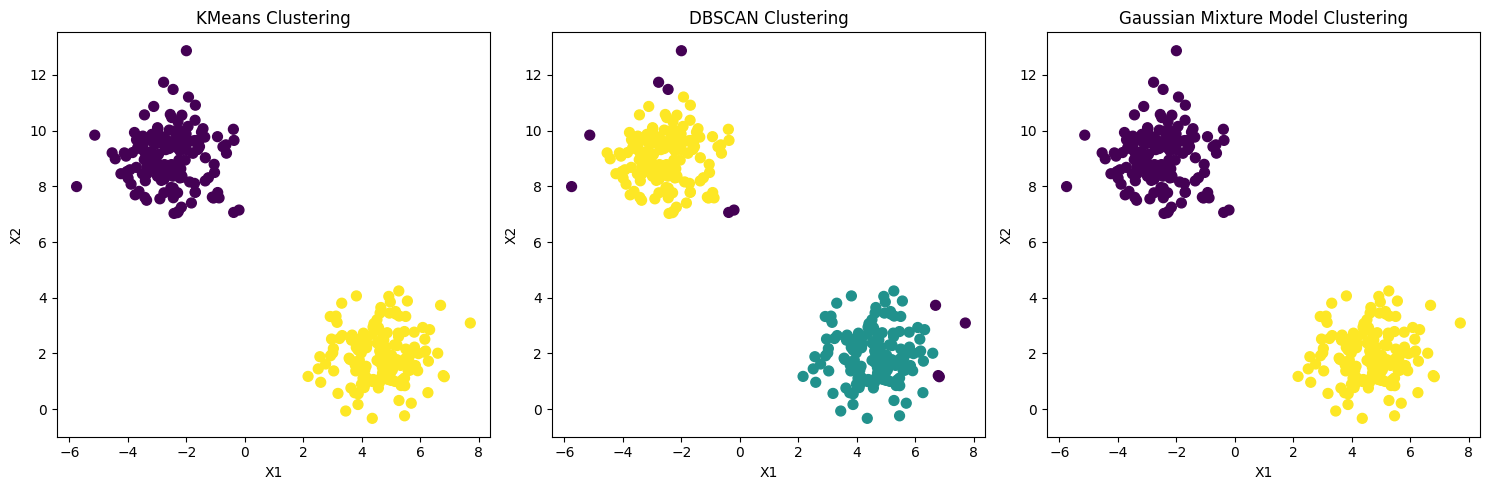

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(blob.iloc[:, 0], blob.iloc[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('KMeans Clustering')
plt.xlabel(blob.columns[0])
plt.ylabel(blob.columns[1])
plt.subplot(1, 3, 2)
plt.scatter(blob.iloc[:, 0], blob.iloc[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel(blob.columns[0])
plt.ylabel(blob.columns[1])
plt.subplot(1, 3, 3)
plt.scatter(blob.iloc[:, 0], blob.iloc[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel(blob.columns[0])
plt.ylabel(blob.columns[1])
plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import silhouette_score
kmeans_silhouette = silhouette_score(blob, kmeans_labels)
dbscan_silhouette = silhouette_score(blob, dbscan_labels)
gmm_silhouette = silhouette_score(blob, gmm_labels)
print(f'KMeans Silhouette Score: {kmeans_silhouette:.2f}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.2f}')
print(f'Gaussian Mixture Model Silhouette Score: {gmm_silhouette:.2f}')

KMeans Silhouette Score: 0.83
DBSCAN Silhouette Score: 0.72
Gaussian Mixture Model Silhouette Score: 0.83


# Interpretar

In [13]:
import sys
sys.path.append('../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

## Kmeans

In [14]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(blob, kmeans_labels, test_size=0.2, random_state=42)


In [15]:
#muestrame los centros de los clusters
centers = kmeans.cluster_centers_
print("KMeans Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

KMeans Cluster Centers:
Cluster 0: [-2.55143224  9.02835242]
Cluster 1: [4.66375945 1.92025297]


In [16]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 1.00


In [17]:
ripper.print_rules()


Reglas para clase: 0
[[X2=8.18-8.72] V [X2=>9.78] V [X2=7.04-8.18] V [X2=8.72-9.32] V [X2=9.32-9.78]]

Reglas para clase: 1
[[X2=2.02-2.74] V [X2=2.74-7.04] V [X2=1.58-2.02] V [X2=1.14-1.58] V [X2=<1.14]]


Decision Tree Accuracy: 1.00


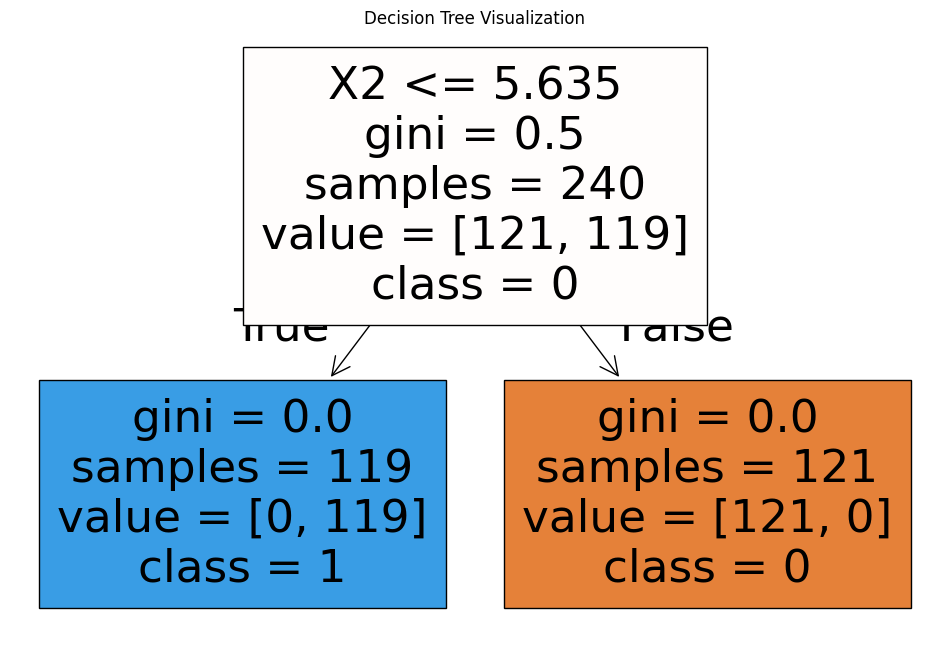

In [18]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [20]:
ds = DSClassifierMultiQ(2, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X = X_train.to_numpy()
losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    

Optimization started

Training time: 7.92s, epochs: 200

Least training loss reached: 0.010


In [21]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.687] R7: X2 > 7.980
			0: 0.687	1: 0.000	Unc: 0.313

	[0.668] R6: 5.495 < X2 < 7.980
			0: 0.668	1: 0.000	Unc: 0.332

	[0.664] R1: -1.531 < X1 < 1.015
			0: 0.664	1: 0.000	Unc: 0.336

	[0.634] R0: X1 < -1.531
			0: 0.634	1: 0.000	Unc: 0.366

Most important rules for class 1

	[0.711] R4: X2 < 3.010
			0: 0.000	1: 0.711	Unc: 0.289

	[0.664] R5: 3.010 < X2 < 5.495
			0: 0.000	1: 0.664	Unc: 0.336

	[0.638] R3: X1 > 3.560
			0: 0.000	1: 0.638	Unc: 0.362

	[0.627] R2: 1.015 < X1 < 3.560
			0: 0.000	1: 0.627	Unc: 0.373


In [22]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 1.00


## DBSCAN

In [23]:
#dividir los datos en entrenamiento y prueba
n_clusters = len(np.unique(dbscan_labels))
max_label = np.max(dbscan_labels)
dbscan_labels = np.where(dbscan_labels == -1, max_label + 1, dbscan_labels)  # Assign a new label for noise points
X_train, X_test, y_train, y_test = train_test_split(blob, dbscan_labels, test_size=0.2, random_state=42)


In [24]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.97


In [25]:
ripper.print_rules()


Reglas para clase: 0
[[X1=3.77-4.53] V [X1=4.97-5.51] V [X1=4.53-4.97] V [X1=-0.41-3.77] V [X1=>5.51^X2=1.58-2.02] V [X1=>5.51^X2=2.02-2.74] V [X1=>5.51^X2=<1.14] V [X1=>5.51]]

Reglas para clase: 1
[[X2=8.18-8.72] V [X2=8.72-9.32] V [X2=9.32-9.78] V [X2=7.04-8.18] V [X2=>9.78]]

Reglas para clase: 2
[[X1=>5.51^X2=1.14-1.58] V [X1=>5.51^X2=2.74-7.04]]


Decision Tree Accuracy: 0.98


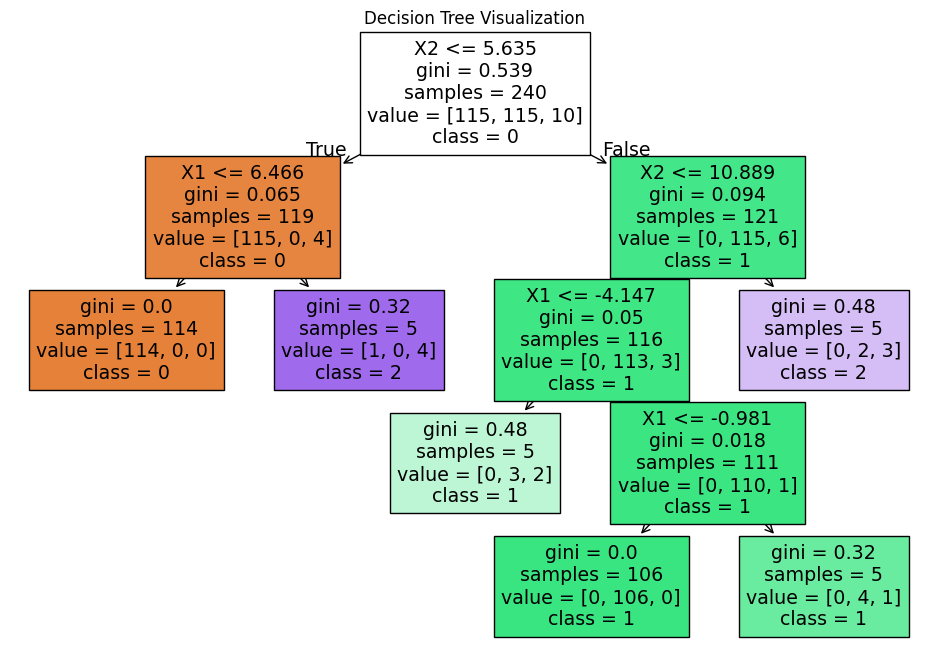

In [26]:
tree = DecisionTreeClassifier(random_state=44, min_samples_leaf=5)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [27]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=blob.columns.tolist())


Optimization started

Training time: 7.95s, epochs: 200

Least training loss reached: 0.034


In [28]:
ds.print_most_important_rules(threshold=0.001)



Most important rules for class 0

	[0.734] R4: X2 < 3.010
			0: 0.734	1: 0.000	2: 0.000	Unc: 0.266

	[0.678] R3: X1 > 3.560
			0: 0.678	1: 0.000	2: 0.000	Unc: 0.322

	[0.666] R2: 1.015 < X1 < 3.560
			0: 0.666	1: 0.000	2: 0.000	Unc: 0.334

	[0.651] R5: 3.010 < X2 < 5.495
			0: 0.651	1: 0.000	2: 0.000	Unc: 0.349

Most important rules for class 1

	[0.713] R1: -1.531 < X1 < 1.015
			0: 0.000	1: 0.713	2: 0.000	Unc: 0.287

	[0.700] R0: X1 < -1.531
			0: 0.000	1: 0.700	2: 0.000	Unc: 0.300

	[0.668] R6: 5.495 < X2 < 7.980
			0: 0.000	1: 0.668	2: 0.000	Unc: 0.332

	[0.666] R7: X2 > 7.980
			0: 0.000	1: 0.666	2: 0.000	Unc: 0.334

Most important rules for class 2


In [29]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.98


## GMM

In [ ]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(blob, gmm_labels, test_size=0.2, random_state=42)


In [ ]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 1.00


In [ ]:
ripper.print_rules()


Reglas para clase: 0
[[X2=8.18-8.72] V [X2=>9.78] V [X2=7.04-8.18] V [X2=8.72-9.32] V [X2=9.32-9.78]]

Reglas para clase: 1
[[X2=2.02-2.74] V [X2=2.74-7.04] V [X2=1.58-2.02] V [X2=1.14-1.58] V [X2=<1.14]]


Decision Tree Accuracy: 1.00


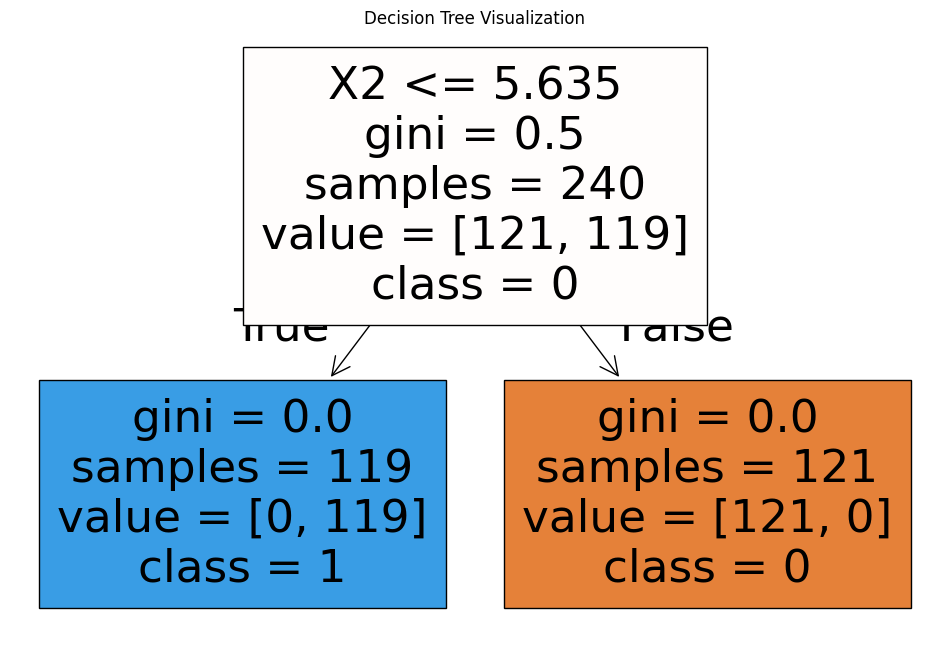

In [ ]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [ ]:
ds = DSClassifierMultiQ(2, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=blob.columns.tolist())


Optimization started

Training time: 7.98s, epochs: 200

Least training loss reached: 0.013


In [ ]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.664] R7: X2 > 7.980
			0: 0.664	1: 0.000	Unc: 0.336

	[0.662] R6: 5.495 < X2 < 7.980
			0: 0.662	1: 0.000	Unc: 0.338

	[0.649] R0: X1 < -1.531
			0: 0.649	1: 0.000	Unc: 0.351

	[0.607] R1: -1.531 < X1 < 1.015
			0: 0.607	1: 0.000	Unc: 0.393

Most important rules for class 1

	[0.649] R3: X1 > 3.560
			0: 0.000	1: 0.649	Unc: 0.351

	[0.635] R4: X2 < 3.010
			0: 0.000	1: 0.635	Unc: 0.365

	[0.620] R5: 3.010 < X2 < 5.495
			0: 0.000	1: 0.620	Unc: 0.380

	[0.588] R2: 1.015 < X1 < 3.560
			0: 0.000	1: 0.588	Unc: 0.412


In [ ]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 1.00
